In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')

In [0]:
from pyemd import emd
import numpy as np
import pandas as pd
from tokenizer import RE_PATTERN
import re

In [0]:
""" EVALUATION OF STYLE TRANSFER INTENSITY

This code is used for evaluation of style transfer intensity (STI) between input and output texts of a style transfer model.
Note that STI, makes use of both the input and the output texts for a more meaningful evaluation.
STI tells how *much* the style changed from the input to the output.

Two output texts could exhibit the same overall target style, but with one being more pronounced than the other,
e.g. "i like this" vs. "i love this !" While past evaluations do not quantify that, STI can,
given style distributions from a style classifier trained on labeled style datasets.

As per [1] STI, based on Earth Mover's Distance (EMD) between style distributions of input and output texts,
exhibited higher correlation with human evaluations of the same texts than did the method of past evaluations
(using target style scores of output texts alone).

Usage:
    - Calculate STI for  input/output text style distributions              -> calculate_direction_corrected_emd(...)

"""


def calculate_emd(input_distribution, output_distribution):
    '''
    Calculate Earth Mover's Distance (aka Wasserstein distance) between
    two distributions of equal length.

    Parameters
    ----------
    input_distribution : numpy.ndarray
        Probabilities assigned to style classes for an input text
    output_distribution : numpy.ndarray
        Probabilities assigned to style classes for an output text, e.g. of a style transfer model

    Returns
    -------
    Earth Mover's Distance (float) between the two given style distributions

    '''

    N = len(input_distribution)
    distance_matrix = np.ones((N, N))
    return emd(input_distribution, output_distribution, distance_matrix)

In [0]:
donor_y = pd.read_csv('/content/drive/My Drive/donor_y.csv')
donor_yhat = pd.read_csv('/content/drive/My Drive/donor_yhat.csv')


In [0]:
emd_calc = []
for i in range(donor_yhat.shape[0]):
    emd_calc.append(calculate_emd(np.array(donor_y, order='C')[i].astype('float64'), np.array(donor_yhat, order='C')[i].astype('float64')))

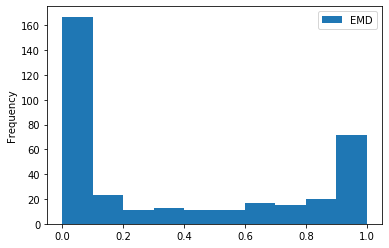

In [7]:
pd.DataFrame(emd_calc, columns=['EMD']).plot.hist();

In [10]:
"""EVALUATION OF NATURALNESS
This is used to evaluate the naturalness of output sentiment texts of examined style transfer models.
For a baseline understanding of what is considered "natural," any method used for automated evaluation of naturalness
also requires an understanding of the human-sourced input texts.
Inspired by the adversarial evaluation approach in "Generating Sentences from a Continuous Space"
(Bowman et al., 2016), we use pretrained unigram logistic regression classifiers and LSTM logistic regression classifiers available from [1]
on samples of input texts and output texts for each style transfer model.
Via adversarial evaluation, the classifiers must distinguish human-generated inputs from machine-generated outputs.
The more natural an output is, the likelier it is to fool an adversarial classifier.

    - Calculate naturalness scores for texts with clf, a NaturalnessClassifier      -> clf.score(...)
You can find examples of more detailed usage commands below.
"""

from collections import Counter
from keras.models import load_model as load_keras_model
from keras.preprocessing.sequence import pad_sequences
from tokenizer import RE_PATTERN
from sklearn.externals import joblib
import re

NATURALNESS_CLASSIFIER_BASE_PATH = '/content/drive/My Drive/NaturalnessClassifier/'
MAX_SEQ_LEN = 30 # for neural classifier

def load_model(path):
    return joblib.load(path)

def invert_dict(dictionary):
    return dict(zip(dictionary.values(), dictionary.keys()))

TEXT_VECTORIZER = load_model('/content/drive/My Drive/vectorizer.pkl')

# adjust vocabulary to account for unknowns
VOCABULARY = TEXT_VECTORIZER.vocabulary_
INVERSE_VOCABULARY = invert_dict(VOCABULARY)
VOCABULARY[INVERSE_VOCABULARY[0]] = len(VOCABULARY)
VOCABULARY['CUSTOM_UNKNOWN'] = len(VOCABULARY)+1




## DATA PREP
def convert_to_indices(text):
    # tokenize input text
    tokens = re.compile(RE_PATTERN).split(text)
    non_empty_tokens = list(filter(lambda token: token, tokens))

    indices = []

    # collect indices of tokens in vocabulary
    for token in non_empty_tokens:
        if token in VOCABULARY:
            index = VOCABULARY[token]
        else:
            index = VOCABULARY['CUSTOM_UNKNOWN']

        indices.append(index)

    return indices

def format_inputs(texts):
    # prepare texts for use in neural classifier
    texts_as_indices = []
    for text in texts:
        texts_as_indices.append(convert_to_indices(text))
    return pad_sequences(texts_as_indices, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0.)

def merge_datasets(dataset1, dataset2):
    x = []
    x.extend(dataset1)
    x.extend(dataset2)
    return x

def load_dataset(path):
    data = []
    with open(path) as f:
        data.append(f.read())
    data = [s.strip() for s in data]
    return data


    
## NATURALNESS CLASSIFIERS
class NaturalnessClassifier:
    '''
    An external classifier was trained for each examined style transfer model -
    more specifically using its inputs and outputs, of course excluding test samples.

    Use UnigramBasedClassifier or NeuralBasedClassifier to load a
    trained classifier and score texts of a given style transfer model.
    The scores represent the probabilities of the texts being 'natural'.

    '''

    pass

class UnigramBasedClassifier(NaturalnessClassifier):
    ''' 
    Might implement in future if neccessary

    '''

class NeuralBasedClassifier(NaturalnessClassifier):
    def __init__(self, style_transfer_model_name):
        self.path = f'{NATURALNESS_CLASSIFIER_BASE_PATH}/neural_{style_transfer_model_name}.h5'
        self.classifier = load_keras_model(self.path)

    def score(self, texts):
        inps = format_inputs(texts)
        distribution = self.classifier.predict(inps)
        scores = distribution.squeeze()
        return scores

    def summary(self):
        return self.classifier.summary()

model = 'ARAE' 


# # load data
generated_1 = ['Her long muscular hands were free, her pink mane kept catching the rays, and the muscles, and the muscles of her hands continued to embrace, as if she suddenly slipped into a womans body.']
generated_2 = ['he sat at the window of the train, brooding, shaking her head, shaking herself, and could not quite make ones feet rest on the floor. The window frame trembled with the speed of the motion, the empty darkness, and dots of light slashed across the glass as luminous streaks, once in a while. Her leg, sculptured by the tight sheen of the stocking, its long line running straight, now developed lateral instep at the base of the heel, accompanied by a small elastic at the tip; it, had a feminine elegance that seemed out of place in the dusty train car and oddly fitting the contours of her profile. She wore the most expensive dress in the world, the most expensive shoes, the most expensive mouth, wrapped shapelessly about her slender, nervous body']
output_texts = merge_datasets(generated_1, generated_2)

# # score
neural_classifier = NeuralBasedClassifier(model)
print(neural_classifier.score(output_texts))

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version pre-0.18 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










[0.05994292 0.981898  ]


In [16]:
"""EVALUATION OF CONTENT PRESERVATION

This code is used for evaluation of content preservation between input and output texts of a style transfer model.

Word Mover's Distance (WMD) on texts with style masking (i.e. placeholders used in place of style words)
exhibited the highest correlation with human evaluations of the same texts as per [1].

Usage:
    - Mask style words in a set of texts prior to evaluation                -> mark_style_words(texts, mask_style=True)
    - Train a Word2Vec model for dataset, for use in WMD calculation   -> train_word2vec_model(...)
    - Calculate WMD scores for  input/output texts                  -> calculate_wmd_scores(...)


"""

from gensim.models.word2vec import Word2Vec
from tokenizer import tokenize

CUSTOM_STYLE = 'customstyle'
STYLE_MODIFICATION_SETTINGS = ['style_masked', 'style_removed']


# DATA PREP
def mark_style_words(texts, style_tokens=None, mask_style=False):
    '''
    Mask or remove style words (based on a set of style tokens) from input texts.

    Parameters
    ----------
    texts : list
        String inputs
    style_tokens : set
        Style tokens
    mask_style : boolean
        Set to False to remove style tokens, True to replace with placeholder

    Returns
    -------
    edited_texts : list
        Texts with style tokens masked or removed

    '''

    edited_texts = []

    for text in texts:
        tokens = tokenize(text)
        edited_tokens = []

        for token in tokens:
            if token.lower() in style_tokens:
                if mask_style:
                    edited_tokens.append(CUSTOM_STYLE)
            else:
                edited_tokens.append(token)

        edited_texts.append(' '.join(edited_tokens))

    return edited_texts


def generate_style_modified_texts(texts):

    # ensure consistent tokenization under different style modification settings
    unmasked_texts = mark_style_words(texts, {})
    texts_with_style_removed = mark_style_words(texts)
    texts_with_style_masked = mark_style_words(texts, mask_style=True)
    return unmasked_texts, texts_with_style_removed, texts_with_style_masked


# MODELS / SCORING OF WMD
def train_word2vec_model(texts, path):
    tokenized_texts = []
    for text in texts:
        tokenized_texts.append(tokenize(text))
    model = Word2Vec(tokenized_texts)
    model.save(path)


def load_word2vec_model(path):
    model = Word2Vec.load(path)
    model.init_sims(replace=True)  # normalize vectors
    return model


def calculate_wmd_scores(references, candidates, wmd_model):
    '''
    Calculate Word Mover's Distance for each (reference, candidate)
    pair in a list of reference texts and candidate texts.

    The lower the distance, the more similar the texts are.

    Parameters
    ----------
    references : list
        Input texts
    candidates : list
        Output texts (e.g. from a style transfer model)
    wmd_model : gensim.models.word2vec.Word2Vec
        Trained Word2Vec model

    Returns
    -------
    wmd_scores : list
        WMD scores for all pairs

    '''

    wmd_scores = []

    for i in range(len(references)):
        wmd = wmd_model.wv.wmdistance(tokenize(references[i]), tokenize(candidates[i]))
        wmd_scores.append(wmd)

    return wmd_scores


# EXAMPLE USAGE (uncomment the following to play around with code)
# load data to train models used for WMD calculations
# all_texts = load_dataset('../data/sentiment.all')
# all_texts_style_masked = mark_style_words(all_texts, mask_style=True)

source_1 = ['It swept space clean, and left nothing but the joy of an unobstructed effort. Only a faint echo within the sounds spoke of that from which the music had escaped, but spoke in laughing astonishment at the discovery that there was no ugliness or pain, and there never had had to be. It was the song of an immense deliverance.']
generated_1 = ['It was a sunburst of sound, breaking out of hiding and spreading open. It had the freedom of release and the tension of purpose. It swept space clean, and at the same time coming empty. The only sound was the coming of breathless, muffled room, but spoke in laughing astonishment at the discovery that there was no ugliness or pain, in fact, there was nothing at all. It was the song of an immense deliverance.']
all_texts = merge_datasets(generated_1, generated_2)

# # train models
w2v_model_path = '/content/drive/My Drive/w2v'
#w2v_model_style_masked_path = '../models/word2vec_masked'
train_word2vec_model(all_texts, w2v_model_path)
# # train_word2vec_model(all_texts_style_masked, w2v_model_style_masked_path)
w2v_model = load_word2vec_model(w2v_model_path)
# w2v_model_style_masked = load_word2vec_model(w2v_model_style_masked_path)
print(calculate_wmd_scores(source_1, generated_1, w2v_model))

# # load texts under different style modification settings
# input_neg_texts = load_dataset('../data/sentiment.test.0')
# input_pos_texts = load_dataset('../data/sentiment.test.1')
# input_texts = merge_datasets(input_neg_texts, input_pos_texts)
#unmasked_inputs, inputs_with_style_removed, inputs_with_style_masked = generate_style_modified_texts(input_texts)

[0.1561831731232212]


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
